# DSAN 6600 Image Style Transfer TEST

In [2]:
import numpy as np
from PIL import Image
import time
from IPython import display
from keras.preprocessing.image import img_to_array
import tensorflow as tf
from keras.applications import vgg19
from tensorflow.python.keras import models

import matplotlib.pyplot as plt

## Define Image Preprocessing Helper Function

In [2]:
def img2arr(path_to_img):
  img = Image.open(path_to_img)
  if img.mode == 'RGBA':
    img = img.convert('RGB')
  scale = 512 / max(img.size)
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)

  img = img_to_array(img)
  img = np.expand_dims(img, axis=0) # add one more dim for batch size
  return img

def imshow(img, title=None):
  out = np.squeeze(img, axis=0).astype('uint8')
  plt.imshow(out)
  if title:
    plt.title(title)
  plt.imshow(out)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and Preprocess Content and Style Image

<ipython-input-2-bdbb02bccb71>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)


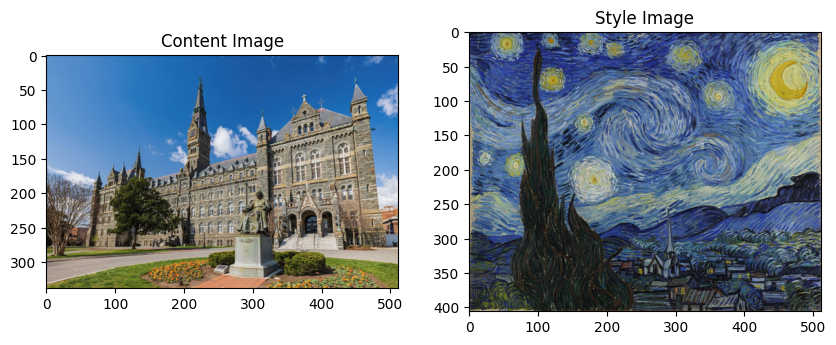

In [11]:
# path to our images
content_path = "/content/drive/MyDrive/6600img/gu.png"
style_path = "/content/drive/MyDrive/6600img/starry_night_full.jpg"

plt.figure(figsize=(10,10))

content = img2arr(content_path).astype('uint8')
style = img2arr(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

## Load VGG19 Pre-trained Model

In [5]:
model = vgg19.VGG19(include_top=False, weights='imagenet')
model.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

## Select VGG19 Layers

In [6]:
# select layers from vgg19 above for our img
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

## Define Loss Function for Content and Style Image

In [7]:
def gram_matrix(input_tensor):
    # the gram matrix is used on the style image outputs
    a = tf.reshape(input_tensor, [-1, int(input_tensor.shape[-1])])
    return tf.matmul(a, a, transpose_a=True) / tf.cast(tf.shape(a)[0], tf.float32)

def compute_loss(model, loss_weight, styled_img, style_features, content_features):

    style_loss, content_loss = 0, 0
    # get model outputs from the styled img
    model_outputs = model(styled_img)
    # style features are the first few layer outputs from model
    style_output_features = model_outputs[:len(style_layers)]
    # content featurea are the last few layer outputs from model
    content_output_features = model_outputs[len(style_layers):]

    # add up style loss of each layer
    for target_style, output in zip(style_features, style_output_features):
        temp_style_loss = tf.reduce_mean(tf.square(gram_matrix(output) - target_style))
        style_loss += 1.0 / float(len(style_layers)) * temp_style_loss
    style_loss *= loss_weight[0]

    # add up content loss of each layer
    for target_content, output in zip(content_features, content_output_features):
        temp_content_loss = tf.reduce_mean(tf.square(output - target_content))
        content_loss += 1.0 / float(len(content_layers)) * temp_content_loss
    content_loss *= loss_weight[1]

    return style_loss+content_loss, style_loss, content_loss

## Define Training Process

In [8]:
tf.compat.v1.enable_eager_execution()
def style_transfer(content_path,
                  style_path,
                  n_epoch=1e3,
                  style_weight=1,
                  content_weight=1e3):


    # load the pretrained vgg19
    net = vgg19.VGG19(include_top=False, weights='imagenet')
    net.trainable = False # no need to train vgg19 weights

    # get the outputs from vgg19 for style and content img
    style_outputs = [net.get_layer(name).output for name in style_layers]
    content_outputs = [net.get_layer(name).output for name in content_layers]

    # build model
    model = models.Model(net.input, style_outputs + content_outputs)
    for layer in model.layers:
        layer.trainable = False


    # load style img and put into model
    style_img = vgg19.preprocess_input(img2arr(style_path))
    style_outputs = model(style_img)
    # style features are the first few layer outputs from model
    # and style features need gram matrix computation
    style_features = [gram_matrix(style_layer[0]) for style_layer in style_outputs[:len(style_layers)]]

    # load style img and put into model
    content_img = vgg19.preprocess_input(img2arr(content_path))
    content_outputs = model(content_img)
    # content features are the last few layer outputs from model
    content_features = [content_layer[0] for content_layer in content_outputs[len(style_layers):]]


    # initialize the ultimate styled img
    init_img = vgg19.preprocess_input(img2arr(content_path))
    init_img = tf.Variable(init_img, dtype=tf.float32)

    optimizer = tf.keras.optimizers.Adam(learning_rate=20, beta_1=0.99, epsilon=1e-1)

    best_loss, best_img = float('inf'), None
    # means of imagenet pics
    norm_means = np.array([103.939, 116.779, 123.68])

    styled_img = [] # to store the best styled images
    all_loss = [[],[],[]] # to store the total loss, style loss, content loss

    for i in range(n_epoch+1):

        start = time.time()
        with tf.GradientTape() as tape:
            loss, style_loss, content_loss = compute_loss(model,
                                                            [style_weight, content_weight],
                                                            init_img,
                                                            style_features,
                                                            content_features)
        all_loss[0].append(loss.numpy())
        all_loss[1].append(style_loss.numpy())
        all_loss[2].append(content_loss.numpy())
        # compute gradients w/ respect to init_img
        gradient = tape.gradient(loss, init_img)

        optimizer.apply_gradients([(gradient, init_img)])
        # make sure the updated init_img is not off limit
        init_img.assign(tf.clip_by_value(init_img, -norm_means, 255 - norm_means))

        if loss < best_loss:
        # update best loss and best img from total loss.
            best_loss = loss

            best_img = init_img.numpy().copy()
            if len(best_img.shape) == 4:
                best_img = np.squeeze(best_img, 0)
            else:
                raise TypeError('Image has incorrect dimensions')
            # perform the inverse of the preprocessing step
            best_img[:, :, 0] += norm_means[0]
            best_img[:, :, 1] += norm_means[1]
            best_img[:, :, 2] += norm_means[2]
            best_img = best_img[:, :, ::-1]
            best_img = np.clip(best_img, 0, 255).astype('uint8')

        if i % 100 == 0:
            # store the latest best_img every 100 epochs
            styled_img.append(best_img)
            # print out the current best img during training
            display.clear_output(wait=True) # clear the previous print
            display.display_png(Image.fromarray(best_img))
            print('Iteration: {} \n'
                    'Total loss: {:.4e}, '
                    'style loss: {:.4e}, '
                    'content loss: {:.4e}, '
                    'time: {:.4f}s'.format(i, loss, style_loss, content_loss, time.time() - start))

    display.clear_output(wait=True) # clear the previous print
    n_rows = n_epoch // (100*5)+1 # rows of imgs in the final output
    plt.figure(figsize=(15, 3*n_rows))
    # print out all the best imgs during training
    for j, img in enumerate(styled_img):
        plt.subplot(n_rows, 5, j+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    return best_img, all_loss

## Hyperparameter Tuning (style-weight)

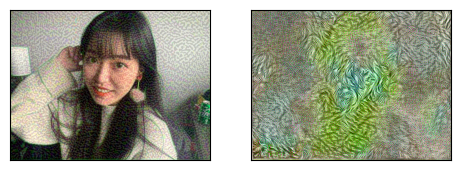

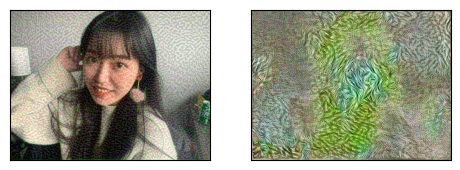

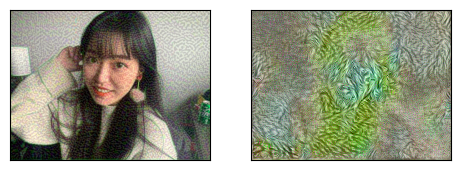

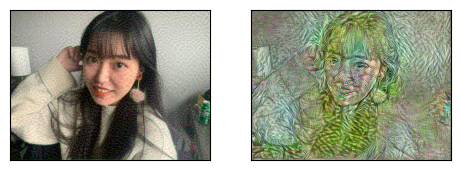

In [ ]:
import pandas as pd

style_weights = [1,.1,.01, .001]
data = []  # Initialize an empty list to store data

for s_w in style_weights:
    best, losses = style_transfer(content_path, style_path, n_epoch=100, style_weight=s_w, content_weight=1e3)
    # Assuming losses = [total_loss_list, style_loss_list, content_loss_list]

    for i in range(100):  # Assuming there are 100 values in each loss list
        data.append({
            'style_weight': s_w,
            'epoch': i+1,
            'total_loss': losses[0][i],
            'style_loss': losses[1][i],
            'content_loss': losses[2][i]
        })

# Create DataFrame from the data
df = pd.DataFrame(data)

## Model Performance by Different Style Weights

In [3]:
#df.to_csv("./hyperparameter_tuning.csv")
#hyper_df = pd.read_csv("./hyperparameter_tuning.csv")

In [4]:
hyper_df.head()

,Unnamed: 0,style_weight,epoch,total_loss,style_loss,content_loss
0,0,1.0,1,5.215565e+09,5.215565e+09,0.0
1,1,1.0,2,1.489613e+10,1.489405e+10,2086447.2
2,2,1.0,3,2.036894e+10,2.036633e+10,2605585.2
3,3,1.0,4,1.222007e+10,1.221763e+10,2448039.2
4,4,1.0,5,1.025339e+10,1.025087e+10,2524374.8


In [5]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [6]:
# Define four distinct aesthetic colors
colors = ['#33CFA5',  # aesthetic teal
          '#F76F8E',  # aesthetic pink
          '#F9C80E',  # aesthetic yellow
          '#664DFF']  # aesthetic purple

# Create a figure with secondary_y (true/false) depending on if you want dual axis plots or not
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces for each location and variable
variables = ['total_loss', 'style_loss', 'content_loss']
weights = hyper_df['style_weight'].unique()

# Initialize the traces dictionary
traces = {variable: [] for variable in variables}

for i, weight in enumerate(weights):
    for j, variable in enumerate(variables):
        traces[variable].append(
            go.Scatter(
                x=hyper_df[hyper_df['style_weight'] == weight]['epoch'],
                y=hyper_df[hyper_df['style_weight'] == weight][variable],
                name=f'{variable} - {weight}',
                visible=(variable == 'total_loss'),  # Only the default variable is visible
                line=dict(color=colors[i % len(colors)])  # Apply the color
            )
        )

# Add traces to the figure
for variable, trace_list in traces.items():
    for trace in trace_list:
        fig.add_trace(trace)

# Create a dropdown menu to select variables
buttons = []
for variable in variables:
    buttons.append(
        dict(
            method='update',
            label=variable,
            args=[{'visible': [variable in trace.name for trace in fig.data]}]  # Toggle visibility
        )
    )

# Update layout with dropdown positioned below the title
fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            pad={'r': 10, 't': 10},
            showactive=True,
            x=0.04,
            xanchor='left',
            y=1.15,
            yanchor='top'
        ),
    ],
    title='Hyperparameter Tuning Performance'
)

# Set x-axis title
fig.update_xaxes(title_text='Epoch')

# Set y-axes titles
fig.update_yaxes(title_text='Loss', secondary_y=False)

# Show figure
fig.show()

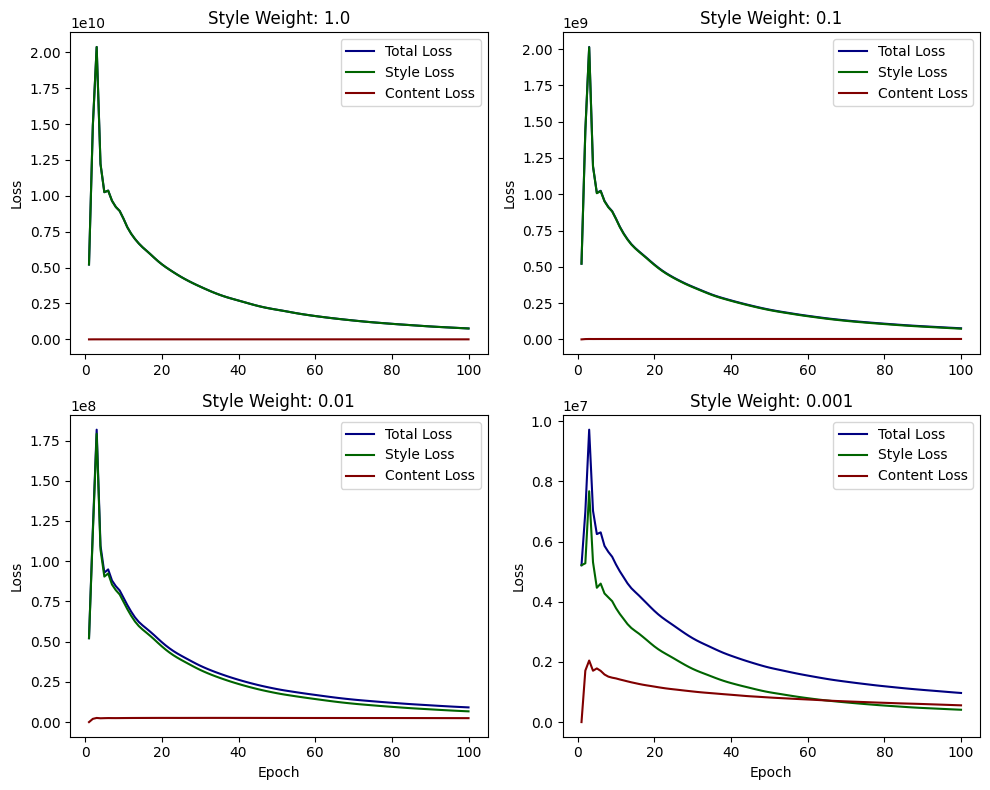

In [7]:
# re-defining unique_style_weights
unique_style_weights = hyper_df['style_weight'].unique()

# creating a 2x2 grid for the subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# flattening the axes array for easy iteration
axes = axes.flatten()

# define the color of the line
color_list = {
    'total_loss': 'navy',   # Dark blue for Total Loss
    'style_loss': 'darkgreen', # Dark green for Style Loss
    'content_loss': 'maroon' # Maroon for Content Loss
}

# plotting each type of loss for each style weight
for i, style_weight in enumerate(unique_style_weights):
    subset = hyper_df[hyper_df['style_weight'] == style_weight]
    axes[i].plot(subset['epoch'], subset['total_loss'], label='Total Loss', color=color_list['total_loss'])
    axes[i].plot(subset['epoch'], subset['style_loss'], label='Style Loss', color=color_list['style_loss'])
    axes[i].plot(subset['epoch'], subset['content_loss'], label='Content Loss', color=color_list['content_loss'])
    axes[i].set_title(f'Style Weight: {style_weight}')
    axes[i].set_ylabel('Loss')
    axes[i].legend()

# setting the x-label for the bottom plots
axes[-2].set_xlabel('Epoch')
axes[-1].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

## Train the Best Model

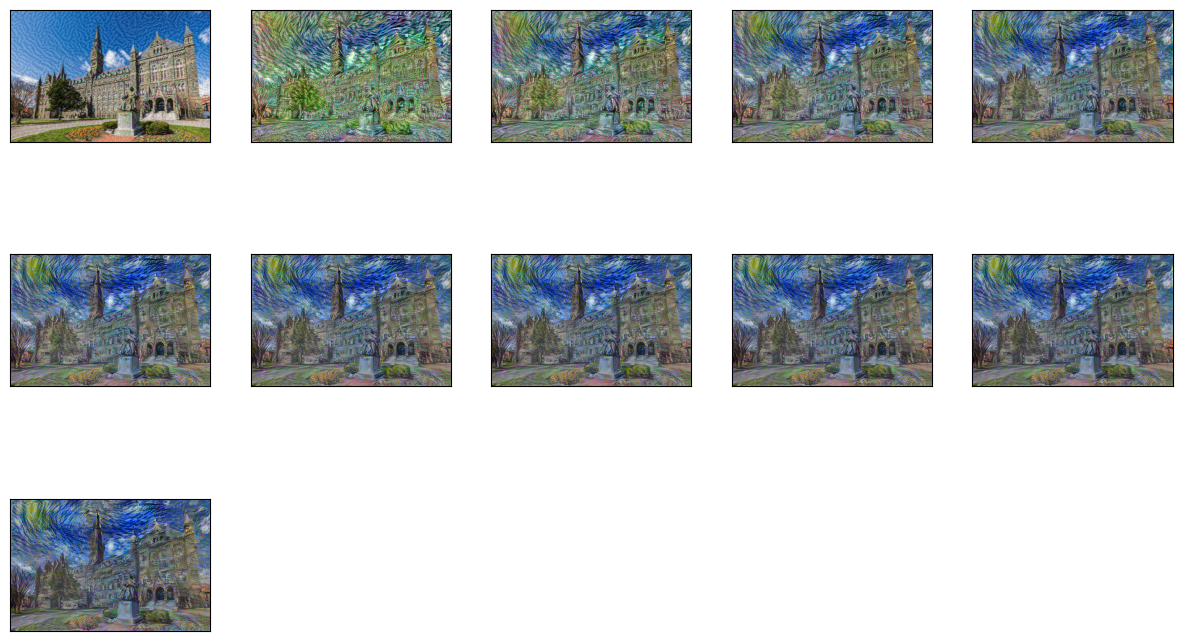

In [12]:
n_epoch = 1000
best_img, all_loss = style_transfer(content_path, style_path, n_epoch=n_epoch,
                          style_weight=1e-3, content_weight=1e3)

## Clips of Result

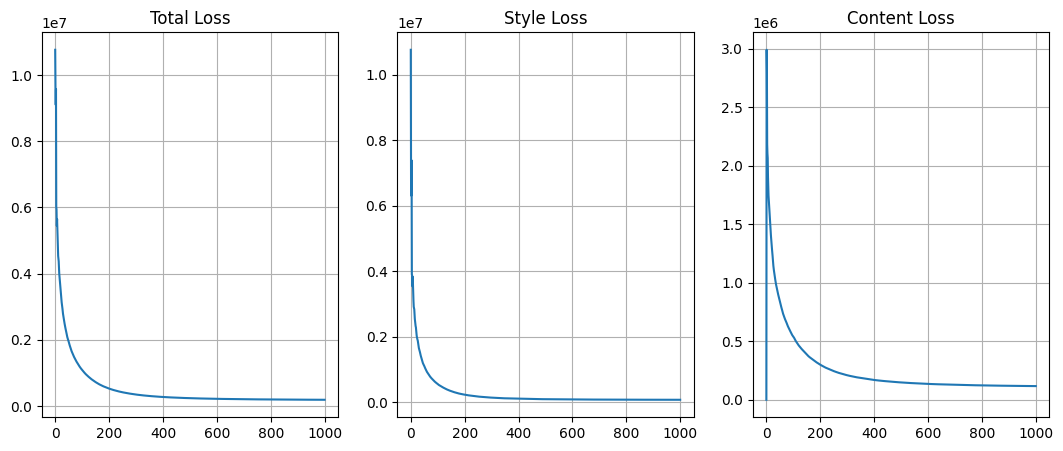

In [13]:
list_loss = ['Total Loss','Style Loss','Content Loss'] # to store the total loss, style loss, content loss
plt.figure(figsize=(13,5))
for i, loss in enumerate(all_loss):
  plt.subplot(1, 3, i+1)
  plt.plot(list(range(n_epoch+1)), loss)
  plt.title(list_loss[i])
  plt.grid()

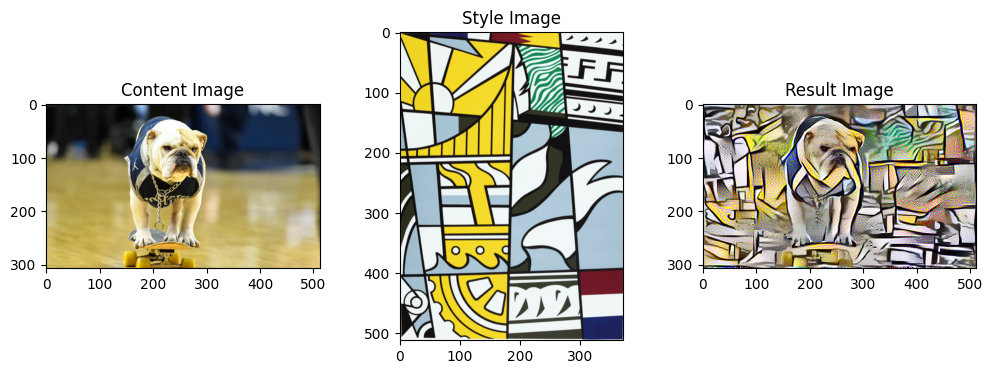

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
imshow(content, 'Content Image')

plt.subplot(1, 3, 2)
imshow(style, 'Style Image')

plt.subplot(1, 3, 3)
plt.imshow(best_img)
plt.title('Result Image')
plt.show()


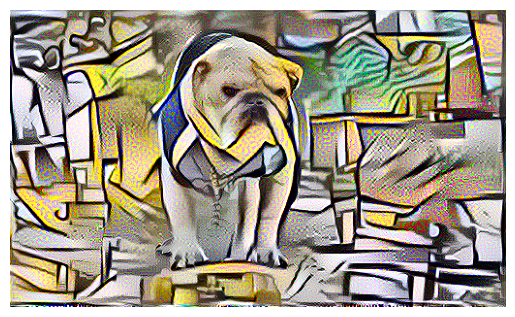

In [ ]:
plt.imshow(best_img)
plt.axis('off')
plt.savefig('gu1.png')